In [11]:
import itertools
import os
from subprocess import check_output

import imageio
import numpy as np
import pandas as pd
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Input
from keras.layers import ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.models import Model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from matplotlib import pyplot as plt
from skimage.transform import resize as imresize
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [24]:
print(check_output(["ls", "e:/plant"]).decode("utf8"))

BATCH_SIZE = 16
EPOCHS = 30
RANDOM_STATE = 11

CLASS = {
    'Black-grass': 0,
    'Charlock': 1,
    'Cleavers': 2,
    'Common Chickweed': 3,
    'Common wheat': 4,
    'Fat Hen': 5,
    'Loose Silky-bent': 6,
    'Maize': 7,
    'Scentless Mayweed': 8,
    'Shepherds Purse': 9,
    'Small-flowered Cranesbill': 10,
    'Sugar beet': 11
}

INV_CLASS = {
    0: 'Black-grass',
    1: 'Charlock',
    2: 'Cleavers',
    3: 'Common Chickweed',
    4: 'Common wheat',
    5: 'Fat Hen',
    6: 'Loose Silky-bent',
    7: 'Maize',
    8: 'Scentless Mayweed',
    9: 'Shepherds Purse',
    10: 'Small-flowered Cranesbill',
    11: 'Sugar beet'
}

sample_submission.csv
test
train



In [37]:
# Dense layers set
def dense_set(inp_layer, n, activation, drop_rate=0.):
    dp = Dropout(drop_rate)(inp_layer)
    dns = Dense(n)(dp)
    bn = BatchNormalization(axis=-1)(dns)
    act = Activation(activation=activation)(bn)
    return act


# Conv. layers set
def conv_layer(feature_batch, feature_map, kernel_size=(3, 3), strides=(1, 1), zp_flag=False):
    if zp_flag:
        zp = ZeroPadding2D((1, 1))(feature_batch)
    else:
        zp = feature_batch
    conv = Conv2D(filters=feature_map, kernel_size=kernel_size, strides=strides)(zp)
    bn = BatchNormalization(axis=3)(conv)
    act = LeakyReLU(1 / 10)(bn)
    return act


# simple model
def get_model():
    inp_img = Input(shape=(51, 51, 3))

    # 51
    conv1 = conv_layer(inp_img, 64, zp_flag=False)
    conv2 = conv_layer(conv1, 64, zp_flag=False)
    mp1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(conv2)
    # 23
    conv3 = conv_layer(mp1, 128, zp_flag=False)
    conv4 = conv_layer(conv3, 128, zp_flag=False)
    mp2 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(conv4)
    # 9
    conv7 = conv_layer(mp2, 256, zp_flag=False)
    conv8 = conv_layer(conv7, 256, zp_flag=False)
    conv9 = conv_layer(conv8, 256, zp_flag=False)
    mp3 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(conv9)
    # 1
    # dense layers
    flt = Flatten()(mp3)
    ds1 = dense_set(flt, 128, activation='tanh')
    out = dense_set(ds1, 12, activation='softmax')

    model = Model(inputs=inp_img, outputs=out)

    # The first 50 epochs are used by Adam opt.
    # Then 30 epochs are used by SGD opt.

    # mypotim = Adam(lr=2 * 1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    mypotim = SGD(lr=1 * 1e-1, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy',
                  optimizer=mypotim,
                  metrics=['accuracy'])
    print(model.summary())
    return model


def get_callbacks(filepath, patience=5):
    lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=1e-5, patience=patience, verbose=1)
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [lr_reduce, msave]


# I trained model about 12h on GTX 950.
def train_model(img, target):
    callbacks = get_callbacks(filepath='model_weight_SGD.hdf5', patience=6)
    gmodel = get_model()
    gmodel.load_weights(filepath='model_weight_Adam.hdf5')
    x_train, x_valid, y_train, y_valid = train_test_split(
        img,
        target,
        shuffle=True,
        train_size=0.8,
        random_state=RANDOM_STATE
    )
    gen = ImageDataGenerator(
        rotation_range=360.,
        width_shift_range=0.3,
        height_shift_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True
    )
    gmodel.fit_generator(gen.flow(x_train, y_train, batch_size=BATCH_SIZE),
                         steps_per_epoch=10 * len(x_train) / BATCH_SIZE,
                         epochs=EPOCHS,
                         verbose=1,
                         shuffle=True,
                         validation_data=(x_valid, y_valid),
                         callbacks=callbacks)


def test_model(img, label):
    gmodel = get_model()
    gmodel.load_weights(filepath='e:/pretrain/model_weight_SGD.hdf5')
    prob = gmodel.predict(img, verbose=1)
    pred = prob.argmax(axis=-1)
    sub = pd.DataFrame({"file": label,
                        "species": [INV_CLASS[p] for p in pred]})
    sub.to_csv("sub.csv", index=False, header=True)


# Resize all image to 51x51
def img_reshape(img):
    img = imresize(img, (51, 51, 3))
    return img


# get image tag
def img_label(path):
    return str(str(path.split('\\')[-1]))


# get plant class on image
def img_class(path):
    return str(path.split('\\')[-2])


# fill train and test dict
def fill_dict(paths, some_dict):
    text = ''
    if 'train' in paths[0]:
        text = 'Start fill train_dict'
    elif 'test' in paths[0]:
        text = 'Start fill test_dict'

    for p in tqdm(paths, ascii=True, ncols=85, desc=text):
        img = imageio.imread(p)
        img = img_reshape(img)
        some_dict['image'].append(img)
        some_dict['label'].append(img_label(p))
        if 'train' in paths[0]:
            some_dict['class'].append(img_class(p))

    return some_dict


# read image from dir. and fill train and test dict
def reader():
    file_ext = []
    train_path = []
    test_path = []

    for root, dirs, files in os.walk('e:/plant'):
        if dirs != []:
            print('Root:\n' + str(root))
            print('Dirs:\n' + str(dirs))
        else:
            for f in files:
                ext = os.path.splitext(str(f))[1][1:]

                if ext not in file_ext:
                    file_ext.append(ext)

                if 'train' in root:
                    path = os.path.join(root, f)
                    train_path.append(path)
                elif 'test' in root:
                    path = os.path.join(root, f)
                    test_path.append(path)
    train_dict = {
        'image': [],
        'label': [],
        'class': []
    }
    test_dict = {
        'image': [],
        'label': []
    }
    
    train_dict = fill_dict(train_path, train_dict)
    test_dict = fill_dict(test_path, test_dict)
    return train_dict, test_dict


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [38]:

train_dict, test_dict = reader()
# X_train = np.array(train_dict['image'])
# y_train = to_categorical(np.array([CLASS[l] for l in train_dict['class']]))


Root:
e:/plant
Dirs:
['test', 'train']
Root:
e:/plant\train
Dirs:
['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']




Start fill train_dict:   0%|                                | 0/4750 [00:00<?, ?it/s]

Start fill train_dict:   0%|                        | 3/4750 [00:00<03:22, 23.45it/s]

Start fill train_dict:   0%|                        | 6/4750 [00:00<03:44, 21.12it/s]

Start fill train_dict:   0%|                        | 8/4750 [00:00<07:22, 10.71it/s]

Start fill train_dict:   0%|                       | 11/4750 [00:01<08:23,  9.42it/s]

Start fill train_dict:   0%|                       | 13/4750 [00:01<09:02,  8.73it/s]

Start fill train_dict:   0%|                       | 16/4750 [00:01<08:37,  9.16it/s]

Start fill train_dict:   0%|                       | 18/4750 [00:01<07:29, 10.52it/s]

Start fill train_dict:   0%|                       | 20/4750 [00:01<06:40, 11.81it/s]

Start fill train_dict:   0%|1                      | 22/4750 [00:02<08:49,  8.93it/s]

Start fill train_dict:   1%|1                      | 24/4750 [00:02<14:45,  5.34it/s]

Start fill train_dict:   1%|1            

Start fill train_dict:   6%|#2                    | 268/4750 [00:21<05:41, 13.11it/s]

Start fill train_dict:   6%|#2                    | 274/4750 [00:21<04:37, 16.11it/s]

Start fill train_dict:   6%|#2                    | 277/4750 [00:22<04:37, 16.14it/s]

Start fill train_dict:   6%|#2                    | 280/4750 [00:22<04:02, 18.40it/s]

Start fill train_dict:   6%|#3                    | 283/4750 [00:22<05:15, 14.16it/s]

Start fill train_dict:   6%|#3                    | 286/4750 [00:22<04:39, 15.97it/s]

Start fill train_dict:   6%|#3                    | 290/4750 [00:22<04:07, 18.01it/s]

Start fill train_dict:   6%|#3                    | 295/4750 [00:22<03:24, 21.79it/s]

Start fill train_dict:   6%|#3                    | 299/4750 [00:23<03:00, 24.68it/s]

Start fill train_dict:   6%|#4                    | 304/4750 [00:23<02:39, 27.93it/s]

Start fill train_dict:   7%|#4                    | 312/4750 [00:23<02:08, 34.53it/s]

Start fill train_dict:   7%|#4             

Start fill train_dict:  17%|###6                  | 788/4750 [00:36<01:06, 59.87it/s]

Start fill train_dict:  17%|###6                  | 795/4750 [00:36<01:16, 51.43it/s]

Start fill train_dict:  17%|###7                  | 803/4750 [00:36<01:10, 56.03it/s]

Start fill train_dict:  17%|###7                  | 810/4750 [00:37<01:13, 53.71it/s]

Start fill train_dict:  17%|###7                  | 816/4750 [00:37<01:15, 52.01it/s]

Start fill train_dict:  17%|###8                  | 822/4750 [00:37<01:16, 51.53it/s]

Start fill train_dict:  17%|###8                  | 830/4750 [00:37<01:08, 56.96it/s]

Start fill train_dict:  18%|###8                  | 837/4750 [00:37<01:07, 58.38it/s]

Start fill train_dict:  18%|###9                  | 846/4750 [00:37<01:00, 64.84it/s]

Start fill train_dict:  18%|###9                  | 853/4750 [00:37<01:20, 48.43it/s]

Start fill train_dict:  18%|###9                  | 859/4750 [00:37<01:17, 50.38it/s]

Start fill train_dict:  18%|####           

Start fill train_dict:  34%|#######              | 1601/4750 [00:49<02:31, 20.73it/s]

Start fill train_dict:  34%|#######              | 1605/4750 [00:49<02:11, 24.01it/s]

Start fill train_dict:  34%|#######1             | 1611/4750 [00:49<01:49, 28.77it/s]

Start fill train_dict:  34%|#######1             | 1615/4750 [00:49<02:01, 25.70it/s]

Start fill train_dict:  34%|#######1             | 1621/4750 [00:50<01:41, 30.97it/s]

Start fill train_dict:  34%|#######1             | 1626/4750 [00:50<01:37, 32.06it/s]

Start fill train_dict:  34%|#######2             | 1630/4750 [00:50<01:52, 27.80it/s]

Start fill train_dict:  34%|#######2             | 1634/4750 [00:50<02:01, 25.70it/s]

Start fill train_dict:  34%|#######2             | 1637/4750 [00:50<01:56, 26.64it/s]

Start fill train_dict:  35%|#######2             | 1641/4750 [00:50<01:46, 29.30it/s]

Start fill train_dict:  35%|#######2             | 1645/4750 [00:50<01:52, 27.71it/s]

Start fill train_dict:  35%|#######2       

Start fill train_dict:  47%|#########8           | 2230/4750 [01:03<01:15, 33.41it/s]

Start fill train_dict:  47%|#########8           | 2235/4750 [01:03<01:29, 28.22it/s]

Start fill train_dict:  47%|#########9           | 2243/4750 [01:03<01:12, 34.81it/s]

Start fill train_dict:  47%|#########9           | 2249/4750 [01:03<01:18, 31.96it/s]

Start fill train_dict:  47%|#########9           | 2254/4750 [01:03<01:23, 30.02it/s]

Start fill train_dict:  48%|#########9           | 2258/4750 [01:04<03:05, 13.44it/s]

Start fill train_dict:  48%|##########           | 2263/4750 [01:04<02:49, 14.63it/s]

Start fill train_dict:  48%|##########           | 2266/4750 [01:05<02:33, 16.17it/s]

Start fill train_dict:  48%|##########           | 2270/4750 [01:05<02:06, 19.54it/s]

Start fill train_dict:  48%|##########           | 2273/4750 [01:05<02:06, 19.65it/s]

Start fill train_dict:  48%|##########           | 2276/4750 [01:05<02:00, 20.48it/s]

Start fill train_dict:  48%|##########     

Start fill train_dict:  58%|############1        | 2752/4750 [01:23<01:40, 19.81it/s]

Start fill train_dict:  58%|############1        | 2756/4750 [01:23<01:37, 20.44it/s]

Start fill train_dict:  58%|############2        | 2760/4750 [01:23<01:23, 23.70it/s]

Start fill train_dict:  58%|############2        | 2765/4750 [01:23<01:10, 28.05it/s]

Start fill train_dict:  58%|############2        | 2772/4750 [01:23<01:02, 31.77it/s]

Start fill train_dict:  58%|############2        | 2777/4750 [01:23<01:06, 29.81it/s]

Start fill train_dict:  59%|############2        | 2781/4750 [01:24<01:28, 22.21it/s]

Start fill train_dict:  59%|############3        | 2788/4750 [01:24<01:20, 24.30it/s]

Start fill train_dict:  59%|############3        | 2792/4750 [01:24<01:12, 27.06it/s]

Start fill train_dict:  59%|############3        | 2796/4750 [01:25<01:52, 17.40it/s]

Start fill train_dict:  59%|############3        | 2802/4750 [01:25<01:31, 21.34it/s]

Start fill train_dict:  59%|############4  

Start fill train_dict:  68%|##############3      | 3238/4750 [01:41<00:23, 65.47it/s]

Start fill train_dict:  68%|##############3      | 3248/4750 [01:41<00:21, 70.50it/s]

Start fill train_dict:  69%|##############3      | 3256/4750 [01:41<00:21, 68.67it/s]

Start fill train_dict:  69%|##############4      | 3264/4750 [01:41<00:21, 69.41it/s]

Start fill train_dict:  69%|##############4      | 3278/4750 [01:41<00:18, 79.09it/s]

Start fill train_dict:  69%|##############5      | 3287/4750 [01:42<00:22, 64.29it/s]

Start fill train_dict:  69%|##############5      | 3301/4750 [01:42<00:20, 72.04it/s]

Start fill train_dict:  70%|##############6      | 3310/4750 [01:42<00:19, 75.46it/s]

Start fill train_dict:  70%|##############6      | 3319/4750 [01:42<00:23, 59.91it/s]

Start fill train_dict:  70%|##############7      | 3326/4750 [01:42<00:24, 57.33it/s]

Start fill train_dict:  70%|##############7      | 3336/4750 [01:42<00:22, 62.58it/s]

Start fill train_dict:  70%|##############8

Start fill train_dict:  84%|#################6   | 3984/4750 [01:54<00:25, 29.91it/s]

Start fill train_dict:  84%|#################6   | 3989/4750 [01:54<00:23, 32.12it/s]

Start fill train_dict:  84%|#################6   | 3994/4750 [01:54<00:21, 34.42it/s]

Start fill train_dict:  84%|#################6   | 3999/4750 [01:55<00:20, 37.16it/s]

Start fill train_dict:  84%|#################7   | 4004/4750 [01:55<00:18, 39.50it/s]

Start fill train_dict:  84%|#################7   | 4009/4750 [01:55<00:19, 38.35it/s]

Start fill train_dict:  85%|#################7   | 4014/4750 [01:55<00:19, 38.27it/s]

Start fill train_dict:  85%|#################7   | 4018/4750 [01:55<00:19, 37.33it/s]

Start fill train_dict:  85%|#################7   | 4024/4750 [01:55<00:17, 41.75it/s]

Start fill train_dict:  85%|#################8   | 4033/4750 [01:55<00:14, 49.03it/s]

Start fill train_dict:  85%|#################8   | 4039/4750 [01:55<00:14, 50.42it/s]

Start fill train_dict:  85%|###############

Start fill train_dict:  94%|###################7 | 4468/4750 [02:09<00:20, 13.86it/s]

Start fill train_dict:  94%|###################7 | 4471/4750 [02:09<00:18, 14.88it/s]

Start fill train_dict:  94%|###################7 | 4473/4750 [02:09<00:19, 14.41it/s]

Start fill train_dict:  94%|###################7 | 4475/4750 [02:09<00:24, 11.34it/s]

Start fill train_dict:  94%|###################7 | 4477/4750 [02:09<00:22, 12.15it/s]

Start fill train_dict:  94%|###################8 | 4480/4750 [02:10<00:20, 13.38it/s]

Start fill train_dict:  94%|###################8 | 4482/4750 [02:10<00:21, 12.61it/s]

Start fill train_dict:  94%|###################8 | 4484/4750 [02:10<00:19, 13.61it/s]

Start fill train_dict:  94%|###################8 | 4488/4750 [02:10<00:15, 16.75it/s]

Start fill train_dict:  95%|###################8 | 4492/4750 [02:10<00:12, 19.87it/s]

Start fill train_dict:  95%|###################8 | 4495/4750 [02:10<00:15, 16.80it/s]

Start fill train_dict:  95%|###############

Start fill test_dict:   3%|7                        | 24/794 [00:00<00:10, 73.74it/s]

Start fill test_dict:   4%|9                        | 31/794 [00:00<00:10, 71.68it/s]

Start fill test_dict:   5%|#2                       | 39/794 [00:00<00:10, 72.98it/s]

Start fill test_dict:   6%|#4                       | 47/794 [00:00<00:10, 74.34it/s]

Start fill test_dict:   7%|#7                       | 57/794 [00:00<00:09, 79.50it/s]

Start fill test_dict:   8%|##                       | 66/794 [00:00<00:08, 82.37it/s]

Start fill test_dict:   9%|##3                      | 75/794 [00:00<00:08, 84.50it/s]

Start fill test_dict:  11%|##6                      | 85/794 [00:01<00:08, 86.02it/s]

Start fill test_dict:  12%|##9                      | 94/794 [00:01<00:08, 84.26it/s]

Start fill test_dict:  13%|###1                    | 103/794 [00:01<00:08, 82.38it/s]

Start fill test_dict:  14%|###3                    | 112/794 [00:01<00:08, 81.11it/s]

Start fill test_dict:  15%|###6            

In [41]:
X = np.array(train_dict['image'])
X_label = to_categorical(np.array([CLASS[l] for l in train_dict['class']]))

X_train, X_test, y_train, y_test = train_test_split(X, X_label, test_size=0.3, random_state=19960214)

gmodel = get_model()
gmodel.load_weights(filepath="e:/pretrain/model_weight_SGD.hdf5")
predY = gmodel.predict(X_test)
predYClasses = np.argmax(predY, axis=1)
trueY = np.argmax(y_test, axis=1)

# print(X_label)

# confusion matrix
confusionMTX = confusion_matrix(trueY, predYClasses)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 51, 51, 3)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 49, 49, 64)        1792      
_________________________________________________________________
batch_normalization_10 (Batc (None, 49, 49, 64)        256       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 49, 49, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 47, 47, 64)        36928     
_________________________________________________________________
batch_normalization_11 (Batc (None, 47, 47, 64)        256       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 47, 47, 64)        0         
__________

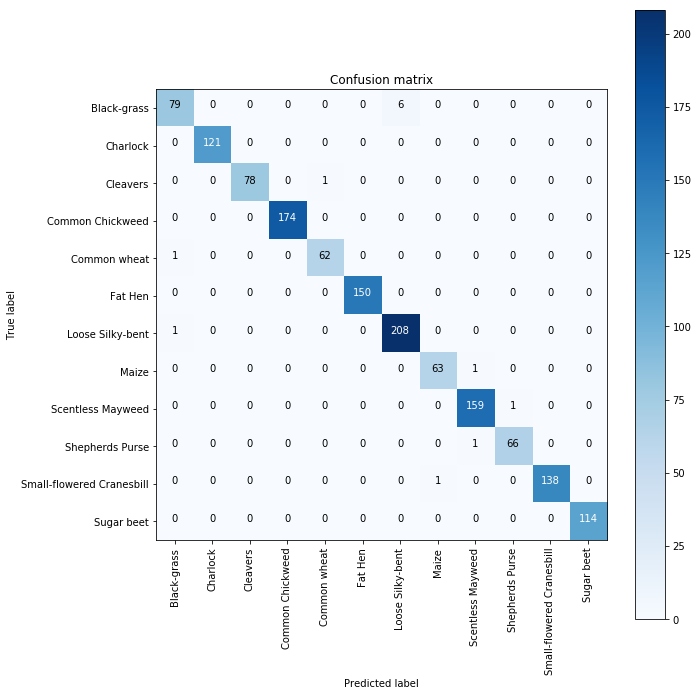

In [42]:
# plot the confusion matrix
plot_confusion_matrix(confusionMTX, classes=CLASS)

# X_test = np.array(test_dict['image'])
# label = test_dict['label']
# test_model(X_test, label)